# Assignment 2: Sequence Labeling

In this assignment you will implement two sequence labeling models (HMMs and CRFs) for the task of named-entity recognition (NER).
- You will start by implementing the count-based MLE estimator for HMM parameters, followed by the Viterbi algorithm for running inference using HMMs.
- Then you will implement the forward algorithm and gradient based MLE training for CRFs.
- Lastly, you will try to improve the CRF by adding extensions.

You should **NOT** call existing CRF libraries in your solution.

**Warning**: As usual, please don't start the day before it is due! Some parts may require significant debugging.

For this assignment we will use the CoNLL 2003 dataset which contains sentences
labeled with 4 types of entities -- PER, ORG, LOC and MISC. We will again filter out rare words and replace them with an `<unk>` token.

**Note**: You do **not** need a GPU for this assignment unless, as part of the extension, you implement a neural CRF. If you do decide to use the GPU, please only do so when needed to avoid getting locked out of colab. You can enable / disable GPU usage by changing the Runtime type under the Runtime menu.

**Grading Rubric**
- 70% results
 - 15% `viterbi_vals.npy` (Viterbi correctness)
 - 15% `hmm_predictions.json` (meets target)
 - 15% `forward_vals.npy` (forward algorithm correctness)
 - 15% `crf_predictions.json` (meets target)
 - 10% `crf_predictions.json` (improvement)
  
- 30% writeup
 - 12.5% clarity
 - 12.5% correctness
 - 5% interestingness of ideas


Before starting on the assignment please make your own copy and rename it `proj_2`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Install some required packages.
!pip install datasets
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 954.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=39211aee6d084956700fc19378c25e3aa1982597b85ec1d92f5266112d1440c7
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
## important imports; feel free to import other libraries here (that don't already implement what you are supposed to).
from collections import defaultdict, Counter, OrderedDict
import torch
import torch.nn as nn
import tqdm
import datasets
import numpy as np
import json

We will use the `datasets` library to load the CoNLL 2003 dataset. An example in this dataset includes a pair of sequences $x$ and $y$, where $x$ is a sequence of tokens and $y$ is a sequence of labels encoded using the BIO scheme. E.g.,

```
x = Singapore Refining Company expected to shut CDU 3.
y = B-ORG I-ORG I-ORG O O O B-ORG I-ORG O
```

In this example, there are two entities present: `Singapore Refining Company`
and `CDU 3`, both of type ORG.

The code below also implements a helper class for sampling batches which contain only sequences of the same length.

In [4]:
## Data setup. 
nerdata = datasets.load_dataset("conll2003")

# get label types and indices
label_types = nerdata["train"].features["ner_tags"].feature.names
label_type2idx = {labeltype: i for i, labeltype in enumerate(label_types)}

# get word types and indices
min_freq = 2 # any word occuring < min_freq times gets <unk>ed
word_counter = Counter()
for example in nerdata["train"]:
    word_counter.update(example["tokens"])
word_types = ["<unk>"] + [wtype for (wtype, wcount) in word_counter.most_common()
                          if wcount >= min_freq]
word_type2idx = {wordtype: i for i, wordtype in enumerate(word_types)}

def word2idx(word):
    return word_type2idx[word] if word in word_type2idx else word_type2idx["<unk>"]

print("labels", label_types, "(total", len(label_types), ")")
print("using a vocabulary of size", len(word_types))

# only keep the tokens and ner tags.
trdata, valdata = nerdata["train"], nerdata["validation"]
trdata.set_format(columns=['tokens', 'ner_tags'])
valdata.set_format(columns=['tokens', 'ner_tags'])

def collate(batchdictseq):
    batchdict = {"tokens": [x["tokens"] for x in batchdictseq]}
    batchdict["ner_tags"] = [x["ner_tags"] for x in batchdictseq]

    wordseqs = torch.LongTensor([[word2idx(word) for word in wordlist] # batchsize x M
                                 for wordlist in batchdict['tokens']])
    tgtseqs = torch.LongTensor(batchdict["ner_tags"]) # these are already indices
    return wordseqs, tgtseqs

class FeaturizedDataset(torch.utils.data.Dataset):
    def __init__(self, list_of_dicts):
        super().__init__()
        self.list_of_dicts = list_of_dicts

    def __getitem__(self, index):
        if isinstance(index, list):
            batch = {}
            for rulidx in index:
                for key, val in self.list_of_dicts[rulidx].items():
                    if key not in batch:
                        batch[key] = [val]
                    else:
                        batch[key].append(val)
            return batch
        return self.list_of_dicts[index]


class ByLengthSampler(torch.utils.data.Sampler):
    """
    Allows for sampling minibatches of examples all of the same sequence length;
    adapted from https://discuss.pytorch.org/t/tensorflow-esque-bucket-by-sequence-length/41284/13.
    """
    def __init__(self, dataset, key, batchsize, shuffle=True):
        # import ipdb
        # ipdb.set_trace()
        self.batchsize = batchsize
        self.shuffle = shuffle
        self.seqlens = torch.LongTensor([len(example[key]) for example in dataset])
        self.nbatches = len(self._generate_batches())

    def _generate_batches(self):
        # shuffle examples
        seqlens = self.seqlens
        perm = torch.randperm(seqlens.size(0)) if self.shuffle else torch.arange(seqlens.size(0))
        batches = []
        len2batch = defaultdict(list)
        for i, seqidx in enumerate(perm):
            seqlen, seqidx = seqlens[seqidx].item(), seqidx.item()
            len2batch[seqlen].append(seqidx)
            if len(len2batch[seqlen]) >= self.batchsize:
                batches.append(len2batch[seqlen][:])
                del len2batch[seqlen]
        # add any remaining batches
        for length, batchlist in len2batch.items():
            if len(batchlist) > 0:
                batches.append(batchlist)
        # shuffle again so we don't always start w/ the most common sizes
        batchperm = torch.randperm(len(batches)) if self.shuffle else torch.arange(len(batches))
        return [batches[idx] for idx in batchperm]

    def batch_count(self):
        return self.nbatches

    def __len__(self):
        return len(self.seqlens)

    def __iter__(self):
        batches = self._generate_batches()
        for batch in batches:
            yield batch

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

labels ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'] (total 9 )
using a vocabulary of size 11983


You will need to submit some predictions from the models you implement to GradeScope for us to grade.  The following will download the required files.

In [5]:
!gdown --id 1zug6hfB1Gq_2UU5oJ5QtOIdNoC0SXnjb
with open("test_data_nolabel.json", "r") as f:
  testdata = json.load(f)
testdata = FeaturizedDataset(testdata)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zug6hfB1Gq_2UU5oJ5QtOIdNoC0SXnjb
To: /content/test_data_nolabel.json
100% 192k/192k [00:00<00:00, 96.2MB/s]


You will also need to submit the outputs of your `viterbi` and `forward_alg` implementations (see below) on Gradescope; the following code will save these outputs.

In [6]:
def save_alg_outputs(alg="viterbi"):
    """
    Please do not edit this function
    """
    bsz, N = 4, 100
    if alg == "viterbi":
        outfi = 'viterbi_vals.npy'
        results = np.zeros((N, bsz, N+1), dtype=np.float32)
    else:
        outfi = 'forward_vals.npy'
        results = np.zeros((N, bsz), dtype=np.float32)

    for i in tqdm.notebook.tqdm(range(2, N+2)):
        torch.manual_seed(int(alg == "viterbi")*590 + i)
        K = torch.randint(2, 11, (1,)).item()
        psi0 = torch.randn(bsz, K)
        psis = torch.randn(bsz, i-1, K, K)
        if alg == "viterbi":
            max_scores, argmax_seqs = viterbi(psi0, psis)
            results[i-2, :, :i] = argmax_seqs.float().numpy()
            results[i-2, :, N] = max_scores.numpy()
        else:
            log_Zs = forward_alg(psi0, psis)
            results[i-2] = log_Zs.numpy()

    np.save(outfi, results)
    print("saved to", outfi)

### Sequence prediction evaluation

We will use the following `eval_predictions` function to get predictions from both HMMs and CRFs and compute precision, recall and F1 scores.

In [7]:
def eval_predictions(loader, model, nbatches=None, show_f1=True):
    """
    Computes predictions and prints the Prec / Rec / F1 scores.

    args:
      - loader: a torch.utils.data.DataLoader
      - model: a SequenceModel (see below) which implements the predict function

    returns:
      - all_preds: a list of all label sequence predictions (themselves lists)
    """
    if not nbatches:
      nbatches=loader.sampler.nbatches
    metric = datasets.load_metric("seqeval")
    all_preds = []
    with torch.no_grad():
        for (X, Y) in tqdm.notebook.tqdm(loader, total=nbatches):
            maxscores, preds = model.predict(X) # batchsize, batchsize x M
            # map label indices back to labels
            preds, Y = preds.tolist(), Y.tolist()
            goldlabels = [[label_types[glabel] for glabel in goldseq]
                          for goldseq in Y]
            predlabels = [[label_types[plabel] for plabel in predseq]
                          for predseq in preds]
            all_preds.extend(predlabels)
            metric.add_batch(predictions=predlabels, references=goldlabels)
    results = metric.compute()
    prec, rec = results['overall_precision'], results['overall_recall']
    f1 = results['overall_f1']
    if show_f1:
        print(f"Precision = {prec:6.3f}, Recall = {rec:6.3f}, F1 = {f1:6.3f}")
    return all_preds, f1


val_batchsize = 8

# set up a validation set loader for running eval_predictions
val_loader = torch.utils.data.DataLoader(valdata, batch_size=1,
    batch_sampler=ByLengthSampler(valdata, 'tokens', val_batchsize, shuffle=False),
    collate_fn=collate)

# HMMs

We have implemented nearly all of a simple hidden markov model (HMM) for you, below. Recall that an HMM can be described by three sets of parameters: the transition matrix $\lambda$, the emission matrix $\phi$ and the initial state distribution $\mu$. The smoothed MLE estimate of each of these is given by,

$$\lambda_{i,j} = \frac{\#(y_{m-1}=i,y_m=j) +\alpha}{\#(y_{m-1}=i) +K\alpha},$$

$$\phi_{i,k} = \frac{\#(y_{m}=i, w_m=k) + \alpha}{\#(y_m=i) +V\alpha},$$

$$\mu_i = \frac{\#(y_0=i) + \alpha}{N + K\alpha},$$

where $K$ is the number of labels, $V$ is vocabulary size, $\#$ is the count of a given label / pair of labels / label and token, and $N$ is the total number of sequences in the training data. We will store these parameters in log space.




### **Implementation task \#1**
Please fill in the rest of the `mle_train` function below, which calculates the HMM parameter estimates from data. We have marked where in particular code needs to be filled in. The `mle_train` function consumes the `trdata` dataset defined above.

After filling in `mle_train` you should be able to run the cell below.

**TLDR:** Implement the rest of the `mle_train` function below and then run the cell below.

In [8]:
class SequenceModel:
    def get_sequence_psis(self, X):
      raise NotImplementedError()

    def predict(self, X):
        """
        Predicts on a single batch. Do not change this function.

        args
          - X: batchsize x M matrix of word type indices
        """
        psi0, psis = self.get_sequence_psis(X)
        return viterbi(psi0, psis)

class HMMModel(SequenceModel):
    def __init__(self, K, V, word2idx):
        """
        args
          - K: an integer number of labels possible for each token
          - V: the integer size of our vocabulary
          - word2idx: a function mapping every possible word type to an index
        """
        self.K, self.V = K, V # nlabels, vocab_size
        # we store transition, emission, and initial log probability matrices
        self.lamb, self.phi, self.mu = None, None, None
        self.word2idx = word2idx

    def mle_train(self, dataset, smoothing=1e-3):
        """
        args
          - dataset: a datasets.arrow_dataset.Dataset (from Huggingface datasets library)
          - smoothing: a float constant to be added to counts to smooth probabilities
        """
        K, V = self.K, self.V
        self.lamb = torch.zeros(K, K) + smoothing # transition probability matrix
        self.phi = torch.zeros(K, V) + smoothing # emission probability matrix
        self.mu = torch.zeros(K) + smoothing # initial state distribution

        self.lamb1 = torch.zeros(K, K)
        self.phi1 = torch.zeros(K, V)
        self.mu1 = torch.zeros(K)

        N = 0

        initial_states = Counter()
        tag_counts = Counter()
        bg_counts = Counter()
        tagemission_counts = Counter()

        for example in tqdm.notebook.tqdm(dataset):
            N += 1
            tokens, ner_tags = example["tokens"], example["ner_tags"]
            word_indices = [self.word2idx(word) for word in tokens]
            # count initial states and all words in two separate counters for ease
            for tag_index in ner_tags:
                tag_counts[tag_index] += 1
            initial_states[ner_tags[0]] += 1
            # count transitions (this is just bigrams)
            for i in range(len(ner_tags) - 1):
                bg_counts[(ner_tags[i], ner_tags[i + 1])] += 1
            # count emissions (this just uses current word and current label)
            if len(ner_tags) != len(word_indices):
              print(len(ner_tags), len(word_indices))
            for j in range(len(ner_tags)):
                i = ner_tags[j]
                k = word_indices[j]
                tagemission_counts[(i, k)] += 1

        # normalize counts to get probabilities
        for tag in initial_states:
            self.mu[tag] += initial_states[tag]

        self.mu /= self.mu.sum()

        for tag in initial_states:
          self.mu1[tag] += (initial_states[tag] + smoothing) / (N + K * smoothing)

        for bg in bg_counts:
          i, j = bg
          self.lamb[i, j] += bg_counts[bg]

        self.lamb /= self.lamb.sum(1, keepdim= True)

        for bg in bg_counts:
          i, j = bg
          self.lamb1[i, j] += (bg_counts[bg] + smoothing) / (tag_counts[i] + K * smoothing)
          break


        for tag in tagemission_counts:
          i, k = tag
          self.phi[i,k] += (tagemission_counts[tag])

        self.phi /= self.phi.sum(1, keepdim=True)

        for tag in tagemission_counts:
          i, k = tag
          self.phi1[i,k] += (tagemission_counts[tag] + smoothing) / (tag_counts[i] + V * smoothing)

    
        # sanity checking
        assert abs(self.mu.sum() - 1) <= 1e-4
        assert torch.all(torch.abs(self.lamb.sum(1) - 1) <= 1e-4)
        assert torch.all(torch.abs(self.phi.sum(1) - 1) <= 1e-4)

        # now log everything
        self.lamb.log_()
        self.phi.log_()
        self.mu.log_()

    def get_sequence_psis(self, X):
        """
        Precalculates scores for a batch of word sequences, so we can run Viterbi.

        args
          - X: batchsize x M matrix of word type indices

        returns
          - psi0: a tensor of real scores (which can be < 0), of dimension batchsize x K
          - psis: a tensor of real scores (which can be < 0), of dimension batchsize x M-1 x K x K
        """
        K = self.K
        lamb, phi, mu = self.lamb, self.phi, self.mu

        # recall that for an HMM, we have:
        #      psi(w_{1:M}, y_m, y_{m-1}, m) = log p(y_m | y_{m-1}) + log p(w_m | y_m).
        # so we'll precalculate these psis for all label-pairs, for all time-steps.

        # select emission probabilities corresponding to first time-step (for each example).
        log_initial_emissions = phi.t()[X[:, 0]] # batchsize x K
        log_initial_probs = mu.view(1, self.K) # 1 x K
        psi0 = log_initial_probs + log_initial_emissions

        # select emission probabilities for the remaining time steps
        log_emissions = phi.t()[X[:, 1:]] # batchsize x M-1 x K
        # unsqueeze dim 2 of emissions since same emissions no matter what previous label was
        log_emissions = log_emissions.unsqueeze(2) # batchsize x M-1 x 1 x K

        # the transition probabilities are the same for every time step (and every example),
        # so we unsqueeze the first 2 phi dimensions.
        log_transitions = lamb.view(1, 1, K, K)

        # add emission log prob for each state and time-step
        psis = log_transitions + log_emissions
        return psi0, psis

hmm = HMMModel(len(label_types), len(word_types), word2idx)
hmm.mle_train(trdata)

  0%|          | 0/14041 [00:00<?, ?it/s]

## The sequence scores defined by HMMs

For HMMs we can define a score at each position $m$ and for every pair of labels as follows:

$$\psi(w_{1:M}, y_m, y_{m-1}, m) = \log p(y_m | y_{m-1}) + \log p(w_m | y_m)$$

Thinking in terms of these local scores (rather than explicit log probabilities) will allow us to easily implement inference algorithms that work for both HMMs and CRFs.

Accordingly, we have implemented the function `get_sequence_psis` in the HMM code above, which uses the trained HMM parameters to compute these local scores. In particular, `get_sequence_psis` returns `psi0` (batch-size x num-labels), the scores for all labels at the *first* position in the sequence, and `psis` (batch-size x (seqlen-1) x num-labels x num-labels), the scores for all possible pairs of labels at the remaining positions in the sequence.

## Viterbi
We are now in a position to implement the Viterbi algorithm, which consumes these local scores and gives us the highest scoring overall sequence and its corresponding score. Below, we have written a `viterbi` function that consumes these `psi0` and `psis` local scores, and which is missing code.


### **Implementation task \#2**
Implement a batched version of the Viterbi algorithm to compute the **max** score among all possible label sequences, and also to return the **argmax**, by filling out the `viterbi` and `backtrace` functions below. The `backtrace` function computes the sequence of labels which lead to the maximum score, given the backpointers across the viterbi table and the highest scoring label at the last time-step.

Once we have a Viterbi implementation we can use the trained HMM to make predictions on the validation set! Running the evaluation code below with your Viterbi implementation should get you an F1 score above 0.76 on the validation set. While we're here, we'll also run your `viterbi` implementation on random scores to check its correctness.

**TLDR**: Complete the `viterbi` and `backtrace` functions below, and then run the cell below.

In [9]:
def viterbi(psi0, psis):
    """
    Computes the Viterbi algorithm.

    args
      - psi0: a tensor of real scores (which can be < 0), of dimension batchsize x K
      - psis: a tensor of real scores (which can be < 0), of dimension batchsize x M-1 x K x K

    returns
      - max_scores: a batchsize tensor of max scores for each sequence
      - preds: a batchsize x M tensor of label indices, where each index is between 0 and K-1
    """
    bsz, K = psi0.size() # batchsize, nlabels
    M = psis.size(1) + 1 # sequence length
    # make our viterbi table data structures
    vtable = psis.new(bsz, M, K).zero_() # stores max scores
    bps = torch.zeros(bsz, M, K, dtype=torch.long, device=vtable.device) # stores backpointers

    # base case: max score of any sequence of length 1 ending in label k is just
    # the score of the first position having label k.
    vtable[:, 0].copy_(psi0)

    # now we fill out the rest of the table...

    for m in range(1, M):
      for k in range(K):
          scores = vtable[:, m - 1] + psis[:, m - 1, :, k]
          max_scores, bps[:, m, k] = torch.max(scores, dim=1)
          vtable[:, m, k] = max_scores

    max_scores, last_labels = torch.max(vtable[:, -1], dim=1)

    argmax_seqs = backtrace(bps, last_labels)
    return max_scores, argmax_seqs

# Implementing the backtrace function
def backtrace(bps, last_labels):
    bsz, M, K = bps.size()
    preds = torch.zeros(bsz, M, dtype=torch.long, device=bps.device)
    preds[:, -1] = last_labels

    for m in range(M - 2, -1, -1):
        preds[:, m] = bps[torch.arange(bsz), m + 1, preds[:, m + 1]]

    return preds


# implement Viterbi before running the following
eval_predictions(val_loader, hmm, val_loader.batch_sampler.nbatches)

# get predictions on the test set and save
test_loader = torch.utils.data.DataLoader(testdata, batch_size=1,
    batch_sampler=ByLengthSampler(testdata, 'tokens', 1, shuffle=False),
    collate_fn=collate)
with open("hmm_predictions.json", "w") as f:
    json.dump(eval_predictions(test_loader, hmm, test_loader.batch_sampler.nbatches, show_f1=False), f)

# run viterbi on random scores
save_alg_outputs(alg="viterbi")

<ipython-input-7-7ad4e6f34bed>:14: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/439 [00:00<?, ?it/s]

Precision =  0.852, Recall =  0.699, F1 =  0.768


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/1060 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/100 [00:00<?, ?it/s]

saved to viterbi_vals.npy


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Validation precision: 0.852

Validation recall: 0.699

Before proceeding please download `hmm_predictions.json` and `viterbi_vals.npy` for submission to GradeScope.

# Linear-chain CRFs

Now let's use linear-chain CRFs to make some predictions. Recall that feature-based linear-chain CRFs define scores at each position for every possible pair of labels given by,

$$\psi(w_{1:M}, y_m, y_{m-1}, m) = \boldsymbol{\theta} \cdot \mathbf{f}(w_{1:M}, y_m, y_{m-1}, m),$$

where $\boldsymbol{\theta}$ is now a vector of free parameters, and the features $\mathbf{f}$ (also a vector) can be arbitrary features extracted for the position $m$. These features are allowed to depend on the whole word sequence $w_{1:M}$, the label at position $m$, and the previous label (at position $m-1$) but nothing else.

## Our particular features
We have implemented a class for extracting features from word sequences. To reduce the number of parameters, we split the features into two parts:

$$\psi(w_{1:M}, y_m, y_{m-1}, m) = \boldsymbol{\theta}_{label} \cdot \mathbf{f}_{label}(w_{1:M}, y_m, m) + \boldsymbol{\theta}_{trans} \cdot \mathbf{f}_{trans}(w_{1:M}, y_m, y_{m-1}, m).$$

The idea here is that the first term in our score will look only at the current label $y_m$, and will make use of many "base" features in scoring the compatibility between $w_m$ and $y_m$ (given $w_{1:M}$). In particular, we will think of $f_{label}$ as consisting of $F_{label}$ base binary features that depend on $w_m$ and $w_{1:M}$.

Since we want a different local score for each pairing of these base features with each possible label for $y_m$ (of which there are $K$), we will in fact need both $\boldsymbol{\theta}_{label}$ and $\mathbf{f}_{label}$ to be $KF_{label}$ dimensional, as described in the textbook. Equivalently, we can view $\mathbf{f}_{label}$ as just being $\mathbf{F}_{label}$ dimensional, and $\boldsymbol{\theta}_{label}$ as being a $K \times F_{label}$ matrix. Then $\boldsymbol{\theta}_{label} \, \mathbf{f}_{label}$ is a matrix-vector product, which gives us a vector of scores, one for each label. And this is in fact how we have implemented it (except in our implementation $\boldsymbol{\theta}_{label}$ is transposed so it has $K$ columns instead of rows, since our implementation uses an `nn.Embedding`).

For the transition scores, $\boldsymbol{\theta}_{trans} \cdot \mathbf{f}_{trans}(w_{1:M}, y_m, y_{m-1}, m)$, we will need a different score now for every *pair* of labels. Thus, interpreted as a matrix, $\boldsymbol{\theta}_{trans}$ will have $K^2$ rows, and $F_{trans}$ columns. To keep this matrix small, we use a small number of transition features. In particular, we will use only a subset of those used in $\mathbf{f}_{label}$. This is implemented in the  `Featurizer` code below.

In [111]:
class Featurizer:
    def __init__(self, label_types):
        self.label_types = label_types

    def featurize_sequence_pair(self, tokens, ner_tags, map_to_indices=True):
        """
        returns an M-length list of feature or feature index lists
        """
        label_types = self.label_types
        features = []
        # we'll make base features here, which are later expanded for each label or label-bigram
        for m, token in enumerate(tokens):
            prev, nexxt = "<s>", "</s>" # previous and next word type
            if m > 0:
                prev = tokens[m-1]
            if m < len(tokens) - 1:
                nexxt = tokens[m+1]
            # make simple binary/indicator base features
            features.append(["curr_word=%s" % token,
                             "prev_word=%s" % prev,
                             "next_word=%s" % nexxt,
                             "isupper=%s" % str(token[0].isupper()),
                             "islower=%s" % str(token[0].islower()),
                             "isdigit=%s" % str(token[0].isdigit()),
                             "isprevupper=%s" % str(prev[0].isupper()),
                             "isprevlower=%s" % str(prev[0].islower()),
                             "isprevdigit=%s" % str(prev[0].isdigit()),
                             "isnextupper=%s" % str(nexxt[0].isupper()),
                             "isnextlower=%s" % str(nexxt[0].islower()),
                             "isnextdigit=%s" % str(nexxt[0].isdigit()),
                             "always_on"])
        if map_to_indices:
            return [[self.feature_type2idx[feat] for feat in feats_m
                     if feat in self.feature_type2idx]
                    for feats_m in features]
        return features

    def is_transition_feature(self, featname):
        """
        This function identifies a subset of the features calculated in featurize_sequence_pair()
        to use as transition features, BASED ON THEIR NAMES.
        If you implement new features above, make sure your feature names are such
        that they don't get repeated for each label pair, unless you want them to.
        """
        return featname.startswith('al') or featname.startswith('is')

    def create_all_feature_types(self, dataset, min_feat_freq=10):
        feat_counter = Counter()
        print("calculating possible features...")
        for example in tqdm.notebook.tqdm(dataset):
            tokens, ner_tags = example["tokens"], example["ner_tags"] # tags are already indices
            # calculate possible features per timestep
            features = self.featurize_sequence_pair(tokens, ner_tags, map_to_indices=False)
            for feats_m in features:
                feat_counter.update(feats_m)

        # prune features that don't occur at least min_feat_freq times
        self.feature_types = [feat for (feat, fcount) in feat_counter.items()
                              if fcount >= min_feat_freq]
        # we're going to pick only a subset of base features to repeat for each transition.
        self.ntransition_feats = sum(1 for featname in self.feature_types
                                     if self.is_transition_feature(featname))
        # sort the feature types so these transition features have lower indices;
        # this way when computing transition scores we can just ignore features with
        # indices that are too high.
        self.feature_types.sort(
            key=lambda featname: -int(self.is_transition_feature(featname)))

        self.feature_type2idx = {feat: i for i, feat in enumerate(self.feature_types)}
        print("num base features:", len(self.feature_type2idx))
        print("num transition base features", self.ntransition_feats)

    def featurize_dataset(self, dataset):
        print("featurizing dataset...")
        featurized_dataset = []
        for example in tqdm.notebook.tqdm(dataset):
            tokens, ner_tags = example["tokens"], example["ner_tags"] # tags are already indices
            # calculate possible features per timestep
            features = self.featurize_sequence_pair(tokens, ner_tags, map_to_indices=True)
            featurized_dataset.append({'featurized_sequence': features, 'ner_tags': ner_tags})
        return FeaturizedDataset(featurized_dataset)

featurizer = Featurizer(label_types)
featurizer.create_all_feature_types(trdata)
featurized_trdata = featurizer.featurize_dataset(trdata) # a list of dicts
featurized_valdata = featurizer.featurize_dataset(valdata)
featurized_testdata = featurizer.featurize_dataset(testdata)

def featurized_collate(batchdictseq):
    batchdict = batchdictseq[0]
    # pad so all timesteps of all examples in the minibatch have the same number
    # of features
    max_nfeats = max(len(feats_m) for feats in batchdict['featurized_sequence']
                     for feats_m in feats)
    pad_idx = len(featurizer.feature_types)
    # make batchsize x M x max_nfeats feature tensors
    featureseqs = torch.LongTensor([[feats_m + [pad_idx] * (max_nfeats - len(feats_m))
                                     for feats_m in feats]
                                    for feats in batchdict['featurized_sequence']])
    tgtseqs = torch.LongTensor(batchdict["ner_tags"]) # these are already indices
    return featureseqs, tgtseqs

crf_batchsize = 64 # feel free to change this

# The following DataLoaders allow for iterating over the featurized_trdata or featurized_valdata
# defined above. These iterators will return two elements, the first of which is a sequence of
# feature vectors for each position in the sentence, and the second of which is a sequence of labels.
# Each feature vector will be a list of indices into all possible features in the dataset.
# Among these indices, the first featurizer.ntransition_feats of them will correspond to
# F_{trans}. You do not need to change anything in the code below or above if you don't want to.

train_feat_loader = torch.utils.data.DataLoader(featurized_trdata, batch_size=1, # hack
    sampler=ByLengthSampler(featurized_trdata, 'featurized_sequence', crf_batchsize, shuffle=True),
    collate_fn=featurized_collate)

val_feat_loader = torch.utils.data.DataLoader(featurized_valdata, batch_size=1,
    sampler=ByLengthSampler(featurized_valdata, 'featurized_sequence', crf_batchsize, shuffle=False),
    collate_fn=featurized_collate)

test_feat_loader = torch.utils.data.DataLoader(featurized_testdata, batch_size=1,
    sampler=ByLengthSampler(featurized_testdata, 'featurized_sequence', 1, shuffle=False),
    collate_fn=featurized_collate)

calculating possible features...


  0%|          | 0/14041 [00:00<?, ?it/s]

num base features: 7141
num transition base features 19
featurizing dataset...


  0%|          | 0/14041 [00:00<?, ?it/s]

featurizing dataset...


  0%|          | 0/3250 [00:00<?, ?it/s]

featurizing dataset...


0it [00:00, ?it/s]

### The CRF module

To train the CRF using gradient descent we will implement it as a PyTorch computation graph (i.e., as a subclass of `nn.Module`). The computation graph will compute the initial scores `psi0` (batch-size x num-labels) and `psis` (batch-size x (seq-len-1) x num-labels x num-labels).

In the code below we have initialized two weight matrices `self.theta_label` and `self.theta_trans` using [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) of size `nbase_feats x K` and `ntransition_feats x K^2`, respectively. Looking up a feature index in either of these matrices will return a vector of size `K` (or `K^2`) which is the contribution of that feature to the score $\psi$ for each label (or pair of labels). These are used to return the initial scores `psi0` and the sequence of scores `psis`.

For now you do not need to change anything in the code below, but you may want to adapt it when you implement an extension to it in the last problem.

In [112]:
class CRF(nn.Module):
    def __init__(self, K, nbase_feats, ntransition_feats):
        super().__init__()
        self.K = K # number of labels
        self.nbase_feats = nbase_feats
        self.ntransition_feats = ntransition_feats
        # We have K weight columns for every feature, which is equivalent to duplicating features
        # for every label, as we discussed in class.
        self.theta_label = nn.Embedding( # reserve last feature for padding which is always zero
            nbase_feats+1, K, padding_idx=nbase_feats)
        self.theta_trans = nn.Embedding( # similarly have a column for each label-bigram
            ntransition_feats+1, K**2, padding_idx=ntransition_feats)
        # initialize with all zeros
        self.theta_label.weight.data.zero_()
        self.theta_trans.weight.data.zero_()

    def forward(self, X):
        """
        args
          - X: batchsize x M x F matrix of feature indices, padded

        returns
          - psi0: a tensor of real scores (which can be < 0), of dimension batchsize x K
          - psis: a tensor of real scores (which can be < 0), of dimension batchsize x M-1 x K x K
        """
        bsz, M, _ = X.size()
        K = self.K
        emission_scores = self.theta_label(X).sum(2) # batchsize x M x K emission scores
        # for transition features we only keep the lowest ntransition_feats features, as discussed
        # in Featurizer and in the text above.
        Xred = X.masked_fill(X > self.ntransition_feats, self.ntransition_feats)
        transition_scores = self.theta_trans( # batchsize x M-1 x K^2 trans scores
            Xred[:, 1:]).sum(2)

        psi0 = emission_scores[:, 0]
        psis = (emission_scores[:, 1:].unsqueeze(2)
                + transition_scores.view(bsz, M-1, self.K, self.K))
        return psi0, psis

### **Implementation task \# 3**

We have provided a class below for training the CRF. In each training iteration, the `crf_nll` function first computes `psi0` and `psis` using the computation graph above. Then it extracts the score of gold label sequence (Y) as well as the sum over all label sequences (using the `forward_alg`) and computes the negative log-likelihood loss using them.

First finish the `crf_nll` function below. Then, implement the `mle_train` function below which will train the CRF for the given number of epochs. This code should be very similar to what you implemented for the Neural Ngram and GRU models in Assignment 1, except you will use `crf_nll` to obtain the loss for each sequence in the batch. Use the `Adagrad` optimizer that we have initialized.

Note that this code will not run correctly until you also implement the `forward_alg` function below. You can track the validation set performance by calling `eval_predictions` and passing `self` as the second argument. Make sure you implement **early stopping**.

**TLDR:** Fill in the `crf_nll` and `mle_train` functions below.

In [113]:
class CRFModel(SequenceModel):
    def __init__(self, K, nbase_feats, ntransition_feats):
        self.K = K
        self.crf = CRF(K, nbase_feats, ntransition_feats)

    def gold_sequence_scores(self, Y, psi0, psis):
        """
        Calculate total scores of a batch of sequences:
            total_score(x, y) = sum_{m=1}^M psi(x, y_{m}, y_{m-1}, m)
        args
          - Y: batchsize x M matrix of label type indices
          - psi0: a tensor of real scores (which can be < 0), of dimension batchsize x K
          - psis: a tensor of real scores (which can be < 0), of dimension batchsize x M-1 x K x K

        N.B.: we don't need X as an argument, because psi0 and psis already
        condition on (i.e., know about) X
        """
        bsz, M = Y.size()
        # create indices [0...batchsize-1], which will be handy for indexing along 0th dimension
        all_example_idxs = torch.arange(bsz).to(Y.device)

        # calculate the true first label's score for each example
        scores = psi0[all_example_idxs, Y[:, 0]] # bsz
        # the above is equivalent to psi0.gather(1, Y[:, 0].unsqueeze(1)).view(-1)

        # add the scores for the remaining time-steps
        for m in range(1, M):
            psis_m = psis[:, m-1] # bsz x K x K
            # for each example get the label at the previous time step and at the current one
            transitions_m = Y[:, m-1:m+1] # bsz x 2
            # for each example add score corresponding to transitioning from label
            # y_{m-1} to label y_m
            scores = scores + psis_m[all_example_idxs, transitions_m[:, 0], transitions_m[:, 1]]

        return scores

    def get_sequence_psis(self, X):
        return self.crf(X)

    def crf_nll(self, X, Y):
        """
        Calculate CRF negative log likelihood.

        args
          - X: batchsize x M x F matrix of feature indices, padded
          - Y: batchsize x M matrix of label type indices
        returns
         - nlls - a batchsize length tensor of negative log likelihoods
        """
        # get psi values for all time steps and all sequences in the batch
        psi0, psis = self.get_sequence_psis(X)

        # score each sequence paired with its true label sequences
        gold_scores = self.gold_sequence_scores(Y, psi0, psis) # batchsize

        # calculate log partition function for each example
        log_Zs = forward_alg(psi0, psis) # batchsize


        nlls = -gold_scores + log_Zs

        return nlls
    def plot_losses(self, train_losses, val_losses):
                    "Plot the training and validation losses."
                    plt.figure(figsize=(10, 6))
                    plt.plot(train_losses, label='Training F1')
                    plt.plot(val_losses, label='Validation F1')
                    plt.xlabel('Epoch')
                    plt.ylabel('F1')
                    plt.title('Training and Validation F1 per Epoch')
                    plt.legend()
                    plt.show()
    def mle_train(self, trloader, valloader, epochs=10):
        lr = 2e-1
        weight_decay = 1e-6
        optim = torch.optim.Adagrad(self.crf.parameters(), lr=lr, weight_decay=weight_decay)
        min_f1 = 0.80

        
        train_f1s = []
        val_f1s = []
        for epoch in range(epochs):
          print('Epoch', epoch)
          for (X, Y) in tqdm.notebook.tqdm(trloader, total=trloader.sampler.nbatches):
              optim.zero_grad()
              nlls = self.crf_nll(X, Y)
              loss = torch.mean(nlls)
              loss.backward()
              optim.step()
          _, train_f1 = eval_predictions(trloader, self)
          train_f1s.append(train_f1)
          _, val_f1 = eval_predictions(valloader, self)
          val_f1s.append(val_f1)
          if val_f1 > min_f1:
              min_f1 = val_f1
              torch.save(self.crf.state_dict(), "crf_base.pt")
              print('saved')
        self.plot_losses(train_f1s, val_f1s)
        if min_f1 > 0.80:
            self.crf.load_state_dict(torch.load("crf_base.pt"))


## The forward algorithm
Before your `crf_nll` function will run, you will need to implement the forward algorithm, which will calculate the log of the sum of all the exponentiated sequence scores. We provide the function `forward_alg`, which is missing code, below.

### **Implementation Task \#4**
 The `forward_alg` function below accepts two arguments: the scores for all labels at the first position in the sequence `psi0` (batch-size x num-labels) and the scores for all possible pairs of labels at each position in the sequence `psis` (batch-size x (seqlen-1) x num-labels x num-labels).

Make sure you only use **PyTorch operations** since we will be backpropagating through the forward algorithm.

Once you have implemented the forward algorithm you can train your model, by running the code below. Your implementation should get an F1 score close to 0.80 on the validation set.

**TLDR:** Complete the `forward_algorithm` function above, and run the cell below.

Epoch 0


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.822, Recall =  0.793, F1 =  0.807


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.787, Recall =  0.747, F1 =  0.766
Epoch 1


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.830, Recall =  0.818, F1 =  0.824


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.791, Recall =  0.770, F1 =  0.781
Epoch 2


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.848, Recall =  0.823, F1 =  0.835


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.797, Recall =  0.764, F1 =  0.780
Epoch 3


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.865, Recall =  0.840, F1 =  0.852


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.818, Recall =  0.779, F1 =  0.798
Epoch 4


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.866, Recall =  0.842, F1 =  0.854


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.814, Recall =  0.779, F1 =  0.796
Epoch 5


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.854, Recall =  0.845, F1 =  0.849


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.794, Recall =  0.779, F1 =  0.786
Epoch 6


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.868, Recall =  0.846, F1 =  0.856


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.809, Recall =  0.775, F1 =  0.792
Epoch 7


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.869, Recall =  0.848, F1 =  0.858


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.810, Recall =  0.781, F1 =  0.795
Epoch 8


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.873, Recall =  0.855, F1 =  0.864


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.815, Recall =  0.786, F1 =  0.800
saved
Epoch 9


  0%|          | 0/260 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]

Precision =  0.875, Recall =  0.857, F1 =  0.866


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/90 [00:00<?, ?it/s]

Precision =  0.813, Recall =  0.786, F1 =  0.800


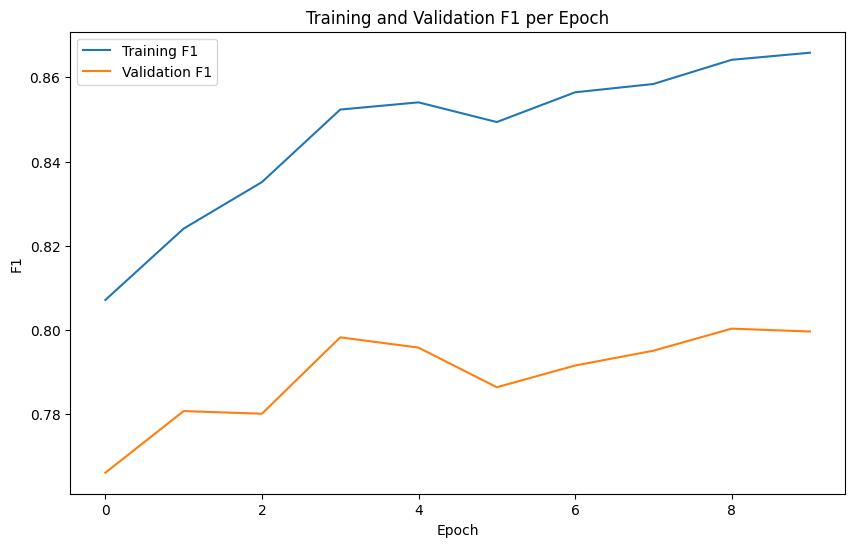

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/1060 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/100 [00:00<?, ?it/s]

saved to forward_vals.npy


In [119]:
def forward_alg(psi0, psis):
    """
    Computes the forward algorithm.

    args
      - psi0: a tensor of real scores (which can be < 0), of dimension batchsize x K
      - psis: a tensor of real scores (which can be < 0), of dimension batchsize x M-1 x K x K

    returns
      - log_Zs: a batchsize tensor of the log of the sum of the possible scores for each x sequence
    """

    bsz, K = psi0.size() # batchsize, nlabels
    M = psis.size(1) + 1 # sequence length

    # make our forward table data structure. it will have entries for only the CURRENT step,
    # since we never need to trace backward; we just want the log of the sum of all the exponentiated scores.
    # moreover, since the base case is the sum of scores of any sequence of length 1
    # ending in label k, and that is just the score of the first position having label k,
    # we will simply set alpha to psi0
    alpha = psi0 # bsz x K stores sum of all possible scores at CURRENT time step

    # update alpha for each remaining time step

    # Note that we want the log of the sum of exponentiated scores.
    # So when adding scores for different labels, intuitively you want to first take an exp,
    # then sum, and then take a log again.
    # You should use torch.logsumexp for this, which is much more stable:
    # https://pytorch.org/docs/stable/generated/torch.logsumexp.html


    for t in range(1, M):
        alpha_expanded = alpha.unsqueeze(2)  # bsz x K x 1
        transition_scores = psis[:, t-1, :, :]  # bsz x K x K
        scores = torch.add(alpha_expanded,transition_scores)  # bsz x K x K
        alpha = torch.logsumexp(scores, dim=1)  # bsz x K


    # at this point alpha should be bsz x K, representing the log of the sum of
    # exponentiated scores for each sequence ending at each possible label.
    # we now obtain total score overall by log-sum-exping over all the possible end labels.
    log_Zs = torch.logsumexp(alpha, dim=1) # bsz

    return log_Zs


device = torch.device('cpu')
crf = CRFModel(len(label_types), len(featurizer.feature_types), featurizer.ntransition_feats)
crf.mle_train(train_feat_loader, val_feat_loader, epochs=10)

# get predictions on the test set and save
with open("crf_predictions.json", "w") as f:
    json.dump(eval_predictions(test_feat_loader, crf, show_f1=False)[0], f)

# run the forward algorithm on random scores
save_alg_outputs(alg="forward")

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

CRF validation precision: 0.815

CRF validation recall: 0.786

Before moving on, please download `crf_predictions.json` and `forward_vals.npy`.

# Experimentation: 1-Page Report

Now it's time for you to experiment.  Try to improve the CRF validation score further. You may either modify the CRF classes above, or copy them in new code cells below and modify them there.

Here are some ideas to try out:
* More or different features. You can modify the code in `Featurizer` to accomplish this.
* Neural CRFs: instead of using linear functions of features to compute your psi local scores, create a new `NeuralCRF` module (which inherits from `nn.Module`) and which computes scores using a neural network of some kind.
  * If you do this, you will likely want to use a different DataLoader from the one used with the feature-based CRF. The following code will create a DataLoader which, when iterated over, returns a `(batchsize x M word indices, batchsize x M label indices)` tuple instead of a `(batchsize x M x F feature indices, batchsize x M label indices)` tuple:

  ```
  train_loader = torch.utils.data.DataLoader(trdata, batch_size=1,
       batch_sampler=ByLengthSampler(trdata, 'tokens', batchsize, shuffle=True),
       collate_fn=collate)
     ```

Note that a significant part of the the test set consists of examples from a different domain. So try to think of features / improvements which would transfer to other domains (such as encyclopedic text).

For this section, you will submit a write-up describing the extensions and/or modifications that you tried.  Your write-up should be **1-page maximum** in length and should be submitted in PDF format.  You may use any editor you like, but we recommend using LaTeX and working in an environment like Overleaf.
For full credit, your write-up should include:
1.   A concise and precise description of the extension that you tried.
2.   A motivation for why you believed this approach might improve your model.
3.   A discussion of whether the extension was effective and/or an analysis of the results.  This will generally involve some combination of tables, learning curves, etc.
4.   A bottom-line summary of your results comparing F1 score of your improvement to the original CRF.
The purpose of this exercise is to experiment, so feel free to try/ablate multiple of the suggestions above as well as any others you come up with!
When you submit the file, please name it `report.pdf`.



In [121]:
# first lets try adding some new features
# noun and verb suffixes from: http://www.uefap.com/vocab/build/building.htm#:~:text=Nouns,%2C%20%2Dage%2C%20%2Dery.
class Featurizer:
    def __init__(self, label_types):
        self.label_types = label_types

    def featurize_sequence_pair(self, tokens, ner_tags, map_to_indices=True):
        """
        returns an M-length list of feature or feature index lists
        """
        label_types = self.label_types
        features = []
        # we'll make base features here, which are later expanded for each label or label-bigram
        nounprefixes = ["anti", "auto", "co", "counter", "dis", "in", "inter", "mis", "re", "super", "un", "pre", "non"]
        nounsuffixes = ["ing", "ed", "ly", "s", "es", "er", "est"]
        verbprefixes = ["re", "dis", "over", "un", "mis", "out", "be", "co", "de", "fore", "inter", "pre", "sub", "trans", "under"]
        verbsuffixes = ["tion", "sion", "er", "ment", "ant", "ent", "age", "al", "ence", "ance", "ery", "ry", "ism", "ship", "ity", "ness", "cy"]
        for m, token in enumerate(tokens):
            prev, nexxt = "<s>", "</s>" # previous and next word type
            if m > 0:
                prev = tokens[m-1]
            if m < len(tokens) - 1:
                nexxt = tokens[m+1]
            # make simple binary/indicator base features
            features.append(["curr_word=%s" % token,
                             "prev_word=%s" % prev,
                             "next_word=%s" % nexxt,
                             "isupper=%s" % str(token[0].isupper()),
                             "islower=%s" % str(token[0].islower()),
                             "isdigit=%s" % str(token[0].isdigit()),
                             "isprevupper=%s" % str(prev[0].isupper()),
                             "isprevlower=%s" % str(prev[0].islower()),
                             "isprevdigit=%s" % str(prev[0].isdigit()),
                             "isnextupper=%s" % str(nexxt[0].isupper()),
                             "isnextlower=%s" % str(nexxt[0].islower()),
                             "isnextdigit=%s" % str(nexxt[0].isdigit()),
                             "is_title_case=%s" % str(token.istitle()),
                             "is_short_word=%s" % str(len(token) <= 3),
                             "is_long_word=%s" % str(len(token) >= 8),
                             "prefix=%s" % token[:2],
                             "suffix=%s" % token[-2:],
                             "len=%s" % str(len(token)),
                             "longprefix=%s" % token[:3],
                             "longsuffix=%s" % token[-3:],
                             "has_punctuation=%s" % str(any(char in "-.:;_{}~+=" for char in token)),
                             "has_nounprefix=%s" % str(any(token.startswith(prefix) for prefix in nounprefixes)),
                             "has_nounsuffix=%s" % str(any(token.endswith(suffix) for suffix in nounsuffixes)),
                             "has_verbprefix=%s" % str(any(token.startswith(prefix) for prefix in verbprefixes)),
                             "has_verbsuffix=%s" % str(any(token.endswith(suffix) for suffix in verbsuffixes)),
                             "prevhas_nounprefix=%s" % str(any(prev.startswith(prefix) for prefix in nounprefixes)),
                             "nexthas_nounsuffix=%s" % str(any(nexxt.endswith(suffix) for suffix in nounsuffixes)),
                             "nexthas_verbprefix=%s" % str(any(nexxt.startswith(prefix) for prefix in verbprefixes)),
                             "prevhas_verbsuffix=%s" % str(any(prev.endswith(suffix) for suffix in verbsuffixes)),
                              "always_on"])

        if map_to_indices:
            return [[self.feature_type2idx[feat] for feat in feats_m
                     if feat in self.feature_type2idx]
                    for feats_m in features]
        return features

    def is_transition_feature(self, featname):
        """
        This function identifies a subset of the features calculated in featurize_sequence_pair()
        to use as transition features, BASED ON THEIR NAMES.
        If you implement new features above, make sure your feature names are such
        that they don't get repeated for each label pair, unless you want them to.
        """
        return featname.startswith('al') or featname.startswith('is')

    def create_all_feature_types(self, dataset, min_feat_freq=10):
        feat_counter = Counter()
        print("calculating possible features...")
        for example in tqdm.notebook.tqdm(dataset):
            tokens, ner_tags = example["tokens"], example["ner_tags"] # tags are already indices
            # calculate possible features per timestep
            features = self.featurize_sequence_pair(tokens, ner_tags, map_to_indices=False)
            for feats_m in features:
                feat_counter.update(feats_m)

        # prune features that don't occur at least min_feat_freq times
        self.feature_types = [feat for (feat, fcount) in feat_counter.items()
                              if fcount >= min_feat_freq]
        # we're going to pick only a subset of base features to repeat for each transition.
        self.ntransition_feats = sum(1 for featname in self.feature_types
                                     if self.is_transition_feature(featname))
        # sort the feature types so these transition features have lower indices;
        # this way when computing transition scores we can just ignore features with
        # indices that are too high.
        self.feature_types.sort(
            key=lambda featname: -int(self.is_transition_feature(featname)))

        self.feature_type2idx = {feat: i for i, feat in enumerate(self.feature_types)}
        print("num base features:", len(self.feature_type2idx))
        print("num transition base features", self.ntransition_feats)

    def featurize_dataset(self, dataset):
        print("featurizing dataset...")
        featurized_dataset = []
        for example in tqdm.notebook.tqdm(dataset):
            tokens, ner_tags = example["tokens"], example["ner_tags"] # tags are already indices
            # calculate possible features per timestep
            features = self.featurize_sequence_pair(tokens, ner_tags, map_to_indices=True)
            featurized_dataset.append({'featurized_sequence': features, 'ner_tags': ner_tags})
        return FeaturizedDataset(featurized_dataset)

featurizer = Featurizer(label_types)
featurizer.create_all_feature_types(trdata)
featurized_trdata = featurizer.featurize_dataset(trdata) # a list of dicts
featurized_valdata = featurizer.featurize_dataset(valdata)
featurized_testdata = featurizer.featurize_dataset(testdata)

def featurized_collate(batchdictseq):
    batchdict = batchdictseq[0]
    # pad so all timesteps of all examples in the minibatch have the same number
    # of features
    max_nfeats = max(len(feats_m) for feats in batchdict['featurized_sequence']
                     for feats_m in feats)
    pad_idx = len(featurizer.feature_types)
    # make batchsize x M x max_nfeats feature tensors
    featureseqs = torch.LongTensor([[feats_m + [pad_idx] * (max_nfeats - len(feats_m))
                                     for feats_m in feats]
                                    for feats in batchdict['featurized_sequence']])
    tgtseqs = torch.LongTensor(batchdict["ner_tags"]) # these are already indices
    return featureseqs, tgtseqs

crf_batchsize = 64 # feel free to change this

# The following DataLoaders allow for iterating over the featurized_trdata or featurized_valdata
# defined above. These iterators will return two elements, the first of which is a sequence of
# feature vectors for each position in the sentence, and the second of which is a sequence of labels.
# Each feature vector will be a list of indices into all possible features in the dataset.
# Among these indices, the first featurizer.ntransition_feats of them will correspond to
# F_{trans}. You do not need to change anything in the code below or above if you don't want to.

train_feat_loader = torch.utils.data.DataLoader(featurized_trdata, batch_size=1, # hack
    sampler=ByLengthSampler(featurized_trdata, 'featurized_sequence', crf_batchsize, shuffle=True),
    collate_fn=featurized_collate)

val_feat_loader = torch.utils.data.DataLoader(featurized_valdata, batch_size=1,
    sampler=ByLengthSampler(featurized_valdata, 'featurized_sequence', crf_batchsize, shuffle=False),
    collate_fn=featurized_collate)

test_feat_loader = torch.utils.data.DataLoader(featurized_testdata, batch_size=1,
    sampler=ByLengthSampler(featurized_testdata, 'featurized_sequence', 1, shuffle=False),
    collate_fn=featurized_collate)

calculating possible features...


  0%|          | 0/14041 [00:00<?, ?it/s]

num base features: 12136
num transition base features 25
featurizing dataset...


  0%|          | 0/14041 [00:00<?, ?it/s]

featurizing dataset...


  0%|          | 0/3250 [00:00<?, ?it/s]

featurizing dataset...


0it [00:00, ?it/s]

### Submission

Upload a submission with the following files to Gradescope:
* proj_2.ipynb (rename to match this exactly)
* hmm_predictions.json
* crf_predictions.json (this should also include all improvements from your exploration)
* viterbi_vals.npy
* forward_vals.npy
* report.pdf

You can upload files individually or as part of a zip file, but if using a zip file be sure you are zipping the files directly and not a folder that contains them.

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.  Note that the test set F1 scores shown by the autograder are on different data from your validation set.  Don't worry if the values seem worse. We will compare your score on the test set to our model's score and assign points based on that.

In [122]:
import matplotlib.pyplot as plt
class CRFModel(SequenceModel):
    def __init__(self, K, nbase_feats, ntransition_feats):
        self.K = K
        self.crf = CRF(K, nbase_feats, ntransition_feats)

    def gold_sequence_scores(self, Y, psi0, psis):
        """
        Calculate total scores of a batch of sequences:
            total_score(x, y) = sum_{m=1}^M psi(x, y_{m}, y_{m-1}, m)
        args
          - Y: batchsize x M matrix of label type indices
          - psi0: a tensor of real scores (which can be < 0), of dimension batchsize x K
          - psis: a tensor of real scores (which can be < 0), of dimension batchsize x M-1 x K x K

        N.B.: we don't need X as an argument, because psi0 and psis already
        condition on (i.e., know about) X
        """
        bsz, M = Y.size()
        # create indices [0...batchsize-1], which will be handy for indexing along 0th dimension
        all_example_idxs = torch.arange(bsz).to(Y.device)

        # calculate the true first label's score for each example
        scores = psi0[all_example_idxs, Y[:, 0]] # bsz
        # the above is equivalent to psi0.gather(1, Y[:, 0].unsqueeze(1)).view(-1)

        # add the scores for the remaining time-steps
        for m in range(1, M):
            psis_m = psis[:, m-1] # bsz x K x K
            # for each example get the label at the previous time step and at the current one
            transitions_m = Y[:, m-1:m+1] # bsz x 2
            # for each example add score corresponding to transitioning from label
            # y_{m-1} to label y_m
            scores = scores + psis_m[all_example_idxs, transitions_m[:, 0], transitions_m[:, 1]]

        return scores

    def get_sequence_psis(self, X):
        return self.crf(X)

    def crf_nll(self, X, Y):
        """
        Calculate CRF negative log likelihood.

        args
          - X: batchsize x M x F matrix of feature indices, padded
          - Y: batchsize x M matrix of label type indices
        returns
         - nlls - a batchsize length tensor of negative log likelihoods
        """
        # get psi values for all time steps and all sequences in the batch
        psi0, psis = self.get_sequence_psis(X)

        # score each sequence paired with its true label sequences
        gold_scores = self.gold_sequence_scores(Y, psi0, psis) # batchsize

        # calculate log partition function for each example
        log_Zs = forward_alg(psi0, psis) # batchsize

        ### Your CODE HERE!!!

        nlls = -gold_scores + log_Zs

        ### END YOUR CODE HERE
        return nlls
    def plot_losses(self, train_losses, val_losses):
                "Plot the training and validation losses."
                plt.figure(figsize=(10, 6))
                plt.plot(train_losses, label='Training F1')
                plt.plot(val_losses, label='Validation F1')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation F1 per Epoch')
                plt.legend()
                plt.show()
    def mle_train(self, trloader, valloader, epochs=10):
        lr = 2e-1
        weight_decay = 1e-5
        optim = torch.optim.Adagrad(self.crf.parameters(), lr=lr, weight_decay=weight_decay)
        min_f1 = 0.85

       
        train_f1s = []
        val_f1s = []
        for epoch in range(epochs):
          print('Epoch', epoch)
          for (X, Y) in tqdm.notebook.tqdm(trloader, total=trloader.sampler.nbatches):
              optim.zero_grad()
              nlls = self.crf_nll(X, Y)
              loss = torch.mean(nlls)
              loss.backward()
              optim.step()
          _, train_f1 = eval_predictions(trloader, self)
          _, val_f1 = eval_predictions(valloader, self)
          train_f1s.append(train_f1)
          val_f1s.append(val_f1)
          if val_f1 > min_f1:
              min_f1 = val_f1
              torch.save(self.crf.state_dict(), "crf.pt")
              print('saved')
        self.plot_losses(train_f1s, val_f1s)
        self.crf.load_state_dict(torch.load("crf.pt"))


In [123]:
def forward_alg(psi0, psis):
    """
    Computes the forward algorithm.

    args
      - psi0: a tensor of real scores (which can be < 0), of dimension batchsize x K
      - psis: a tensor of real scores (which can be < 0), of dimension batchsize x M-1 x K x K

    returns
      - log_Zs: a batchsize tensor of the log of the sum of the possible scores for each x sequence
    """

    bsz, K = psi0.size() # batchsize, nlabels
    M = psis.size(1) + 1 # sequence length

    # make our forward table data structure. it will have entries for only the CURRENT step,
    # since we never need to trace backward; we just want the log of the sum of all the exponentiated scores.
    # moreover, since the base case is the sum of scores of any sequence of length 1
    # ending in label k, and that is just the score of the first position having label k,
    # we will simply set alpha to psi0
    alpha = psi0 # bsz x K stores sum of all possible scores at CURRENT time step

    # update alpha for each remaining time step

    # Note that we want the log of the sum of exponentiated scores.
    # So when adding scores for different labels, intuitively you want to first take an exp,
    # then sum, and then take a log again.
    # You should use torch.logsumexp for this, which is much more stable:
    # https://pytorch.org/docs/stable/generated/torch.logsumexp.html



    for t in range(1, M):
        alpha_expanded = alpha.unsqueeze(2)  # bsz x K x 1
        transition_scores = psis[:, t-1, :, :]  # bsz x K x K
        scores = torch.add(alpha_expanded,transition_scores)  # bsz x K x K
        alpha = torch.logsumexp(scores, dim=1)  # bsz x K


    # at this point your alpha should be bsz x K, representing the log of the sum of
    # exponentiated scores for each sequence ending at each possible label.
    # we now obtain total score overall by log-sum-exping over all the possible end labels.
    log_Zs = torch.logsumexp(alpha, dim=1) # bsz

    return log_Zs


device = torch.device('cpu')
crf = CRFModel(len(label_types), len(featurizer.feature_types), featurizer.ntransition_feats)
# crf.mle_train(train_feat_loader, val_feat_loader, epochs=20)
crf.crf.load_state_dict(torch.load("/content/drive/MyDrive/CS572- proj_2/crf.pt"))
crf.crf.to(device)
# get predictions on the test set and save
with open("crf_predictions.json", "w") as f:
    json.dump(eval_predictions(test_feat_loader, crf, show_f1=False)[0], f)

# run the forward algorithm on random scores
save_alg_outputs(alg="forward")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/1060 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/100 [00:00<?, ?it/s]

saved to forward_vals.npy
